In [43]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, log_loss, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import os
import shap
from scipy.sparse import issparse


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU usage

In [3]:
newsgroups = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
df = pd.DataFrame({'text': newsgroups.data, 'target': newsgroups.target})
df.head()

,text,target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


In [4]:
df['target_name'] = df['target'].apply(lambda x: newsgroups.target_names[x])
df.head()

,text,target,target_name
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware


In [5]:
def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # remove non-letters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [6]:
df['clean_text'] = df['text'].apply(clean_text)
df.head()

,text,target,target_name,clean_text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey,from mamatha devineni ratnam subject pens fans...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware,from mblawsonmidwayecnuoknoredu matthew b laws...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast,from hilmierdsvsuse hilmi eren subject re arme...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware,from guydaustinibmcom guy dawson subject re id...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware,from alexander samuel mcdiarmid subject driver...


In [7]:
X = df['clean_text']
y = df['target_name']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# Convert categories to integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# One-hot encode
y_train_oh = to_categorical(y_train_enc)
y_test_oh = to_categorical(y_test_enc)

num_classes = y_train_oh.shape[1]
print(f"Number of classes: {num_classes}")

Number of classes: 20


In [11]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigram + bigram
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

- 512 → 256 neurons: more representational power but still laptop-friendly
- BatchNormalization: normalizes layer outputs to improve stability
- LeakyReLU: small slope for negative inputs (prevents neuron death)
- Dropout(0.4 / 0.3): regularization to reduce overfitting

In [12]:
input_dim = X_train_tfidf.shape[1]

model = Sequential([
    Dense(512, input_dim=input_dim),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2025-09-26 20:38:31.181748: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,700,052 (10.30 MB)

 Trainable params: 2,698,516 (10.29 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_tfidf.toarray(), y_train_oh,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6652 - loss: 1.1695 - val_accuracy: 0.5302 - val_loss: 2.3440
Epoch 2/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9303 - loss: 0.2658 - val_accuracy: 0.7968 - val_loss: 1.2297
Epoch 3/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9769 - loss: 0.1025 - val_accuracy: 0.8292 - val_loss: 0.6093
Epoch 4/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9881 - loss: 0.0586 - val_accuracy: 0.8322 - val_loss: 0.5892
Epoch 5/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9918 - loss: 0.0431 - val_accuracy: 0.8273 - val_loss: 0.6263
Epoch 6/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9942 - loss: 0.0290 - val_accuracy: 0.8269 - val_loss: 0.6534
Epoch 7/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9949 - loss: 0.0253 - val_accuracy: 0.8266 - val_loss: 0.6926


In [16]:
loss, acc = model.evaluate(X_test_tfidf.toarray(), y_test_oh, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

Test Accuracy: 0.8432, Test Loss: 0.5497


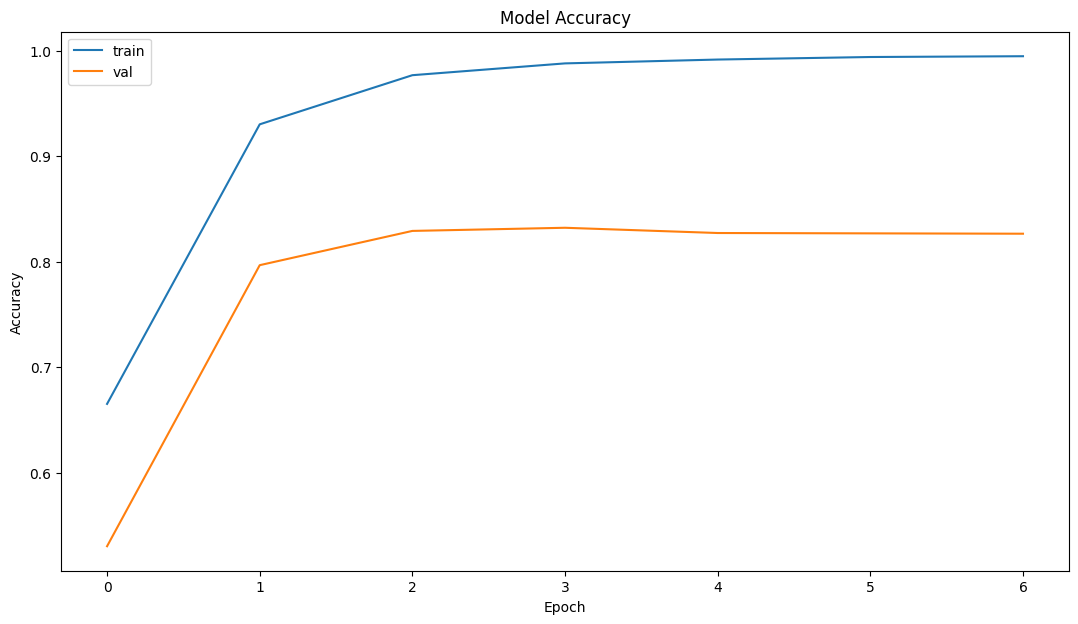

In [18]:
plt.figure(figsize=(13,7))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

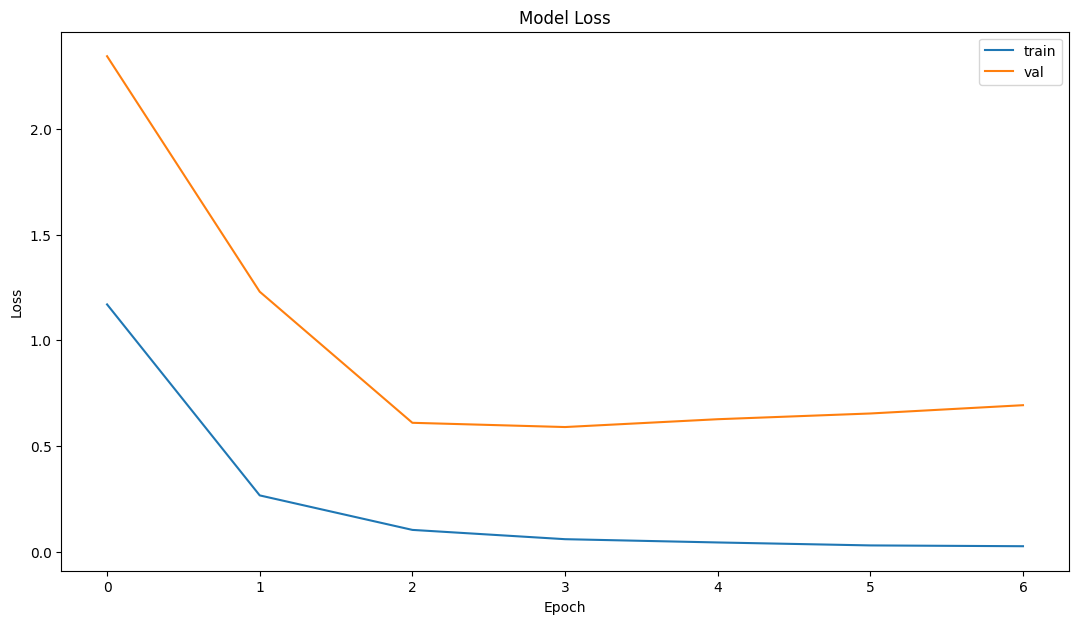

In [19]:
plt.figure(figsize=(13,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
y_pred_probs = model.predict(X_test_tfidf.toarray())
y_pred = np.argmax(y_pred_probs, axis=1)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [24]:
y_pred = np.argmax(model.predict(X_test_tfidf.toarray()), axis=1)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                          precision    recall  f1-score   support

             alt.atheism       0.83      0.82      0.83       160
           comp.graphics       0.65      0.75      0.70       195
 comp.os.ms-windows.misc       0.80      0.81      0.80       197
comp.sys.ibm.pc.hardware       0.78      0.63      0.70       196
   comp.sys.mac.hardware       0.78      0.81      0.80       193
          comp.windows.x       0.86      0.84      0.85       198
            misc.forsale       0.82      0.84      0.83       195
               rec.autos       0.87      0.84      0.85       198
         rec.motorcycles       0.90      0.86      0.88       199
      rec.sport.baseball       0.90      0.89      0.90       199
        rec.sport.hockey       0.94      0.94      0.94       200
               sci.crypt       0.95      0.92      0.94       198
         sci.electronics       0.75      0.82      0.78       197
                 sci.med       0.8

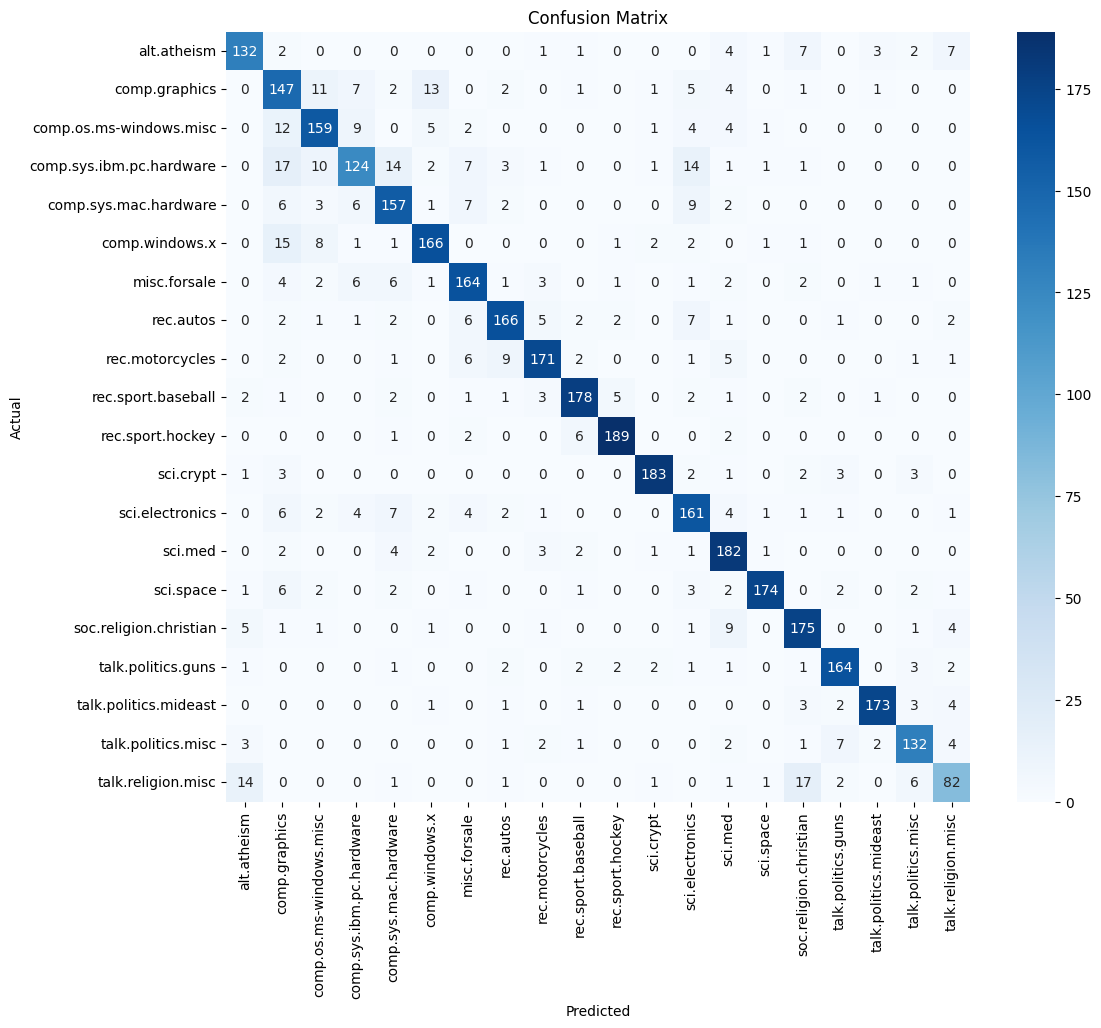

In [26]:
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


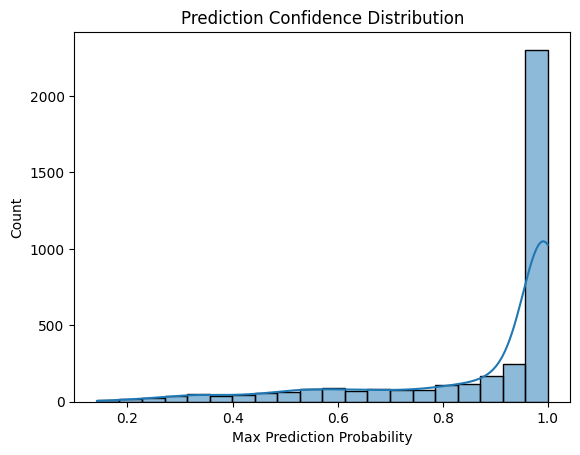

In [27]:
y_prob = model.predict(X_test_tfidf.toarray())
y_prob_max = np.max(y_prob, axis=1)
sns.histplot(y_prob_max, bins=20, kde=True)
plt.xlabel("Max Prediction Probability")
plt.title("Prediction Confidence Distribution")
plt.show()

In [29]:
roc_auc = roc_auc_score(y_test_oh, y_prob, multi_class='ovr')
print(f"ROC-AUC (one-vs-rest): {roc_auc:.4f}")

ROC-AUC (one-vs-rest): 0.9898


In [31]:
# One-hot true labels
y_true_oh = y_test_oh

# Residuals
residuals = y_true_oh - y_prob  # shape: (num_samples, num_classes)

# Residuals close to 0 → model predicts confidently and correctly
# Residuals close to 1 → model predicts incorrectly or with low confidence

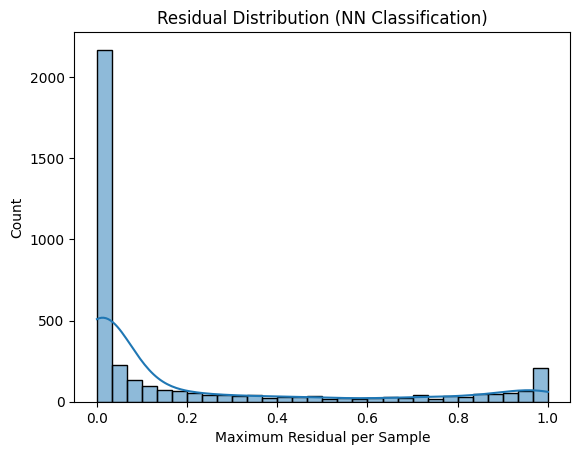

In [32]:
max_residual = np.max(np.abs(residuals), axis=1)  # max abs error per sample
sns.histplot(max_residual, bins=30, kde=True)
plt.xlabel("Maximum Residual per Sample")
plt.title("Residual Distribution (NN Classification)")
plt.show()

In [33]:
# Residual per class (average over all samples)
residual_per_class = np.mean(np.abs(residuals), axis=0)

for cls, res in zip(le.classes_, residual_per_class):
    print(f"{cls}: Average residual = {res:.3f}")

alt.atheism: Average residual = 0.019
comp.graphics: Average residual = 0.036
comp.os.ms-windows.misc: Average residual = 0.026
comp.sys.ibm.pc.hardware: Average residual = 0.033
comp.sys.mac.hardware: Average residual = 0.024
comp.windows.x: Average residual = 0.021
misc.forsale: Average residual = 0.021
rec.autos: Average residual = 0.021
rec.motorcycles: Average residual = 0.017
rec.sport.baseball: Average residual = 0.017
rec.sport.hockey: Average residual = 0.010
sci.crypt: Average residual = 0.010
sci.electronics: Average residual = 0.028
sci.med: Average residual = 0.022
sci.space: Average residual = 0.013
soc.religion.christian: Average residual = 0.020
talk.politics.guns: Average residual = 0.014
talk.politics.mideast: Average residual = 0.009
talk.politics.misc: Average residual = 0.017
talk.religion.misc: Average residual = 0.023


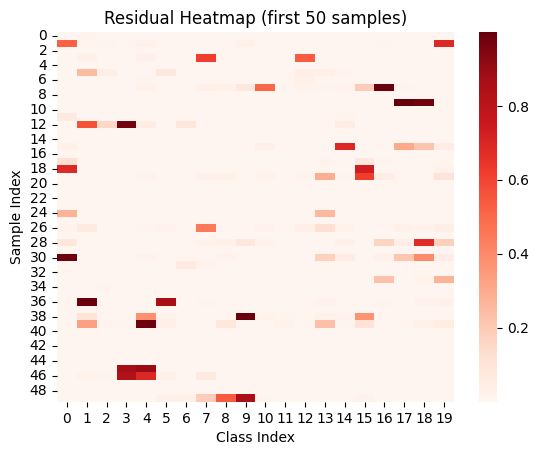

In [35]:
sns.heatmap(np.abs(residuals[:50]), cmap='Reds', annot=False)
plt.xlabel("Class Index")
plt.ylabel("Sample Index")
plt.title("Residual Heatmap (first 50 samples)")
plt.show()

In [38]:
# Use a small sample for background (to save memory)
background = X_train_tfidf.toarray()[np.random.choice(X_train_tfidf.shape[0], 100, replace=False)]

# Explainer
explainer = shap.KernelExplainer(model.predict, background)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [41]:
# Pick 50 test samples to explain
X_sample = X_test_tfidf[np.random.choice(X_test_tfidf.shape[0], 50, replace=False)]

In [44]:
# Wrap predict function to handle sparse matrix
def predict_proba_safe(X):
    if issparse(X):
        return model.predict(X.toarray())  # convert sparse to dense
    else:
        return model.predict(X)           # already dense
explainer = shap.KernelExplainer(predict_proba_safe, background)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [45]:
shap_values = explainer.shap_values(X_sample, nsamples=100)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.905e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.193e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
T

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.054e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.271e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.881e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.704e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.173e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.680e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.759e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.231e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.502e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.761e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.208e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.371e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.685e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.825e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.013e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.911e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.849e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.440e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.259e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.552e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.379e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.078e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.052e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=5.518e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.641e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.324e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.476e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.796e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.213e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.599e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.975e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.546e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.150e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.516e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.929e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.396e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.698e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.091e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=5.800e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.316e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.179e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.060e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.758e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.008e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.526e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.042e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.562e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.762e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.768e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.875e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.265e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.431e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.291e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.614e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.081e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=7.614e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.492e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.613e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.272e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.681e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.277e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.602e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.430e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.936e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.166e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.061e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.310e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.798e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.332e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.370e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.392e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.710e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.515e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.992e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.146e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.085e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.495e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.486e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.055e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.494e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.187e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.852e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.485e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.112e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.790e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.032e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.720e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.086e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.946e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.263e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.364e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.591e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.391e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=7.717e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.545e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.400e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.852e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.426e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.961e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.752e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.129e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.785e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.085e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.829e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.980e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.990e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.731e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.445e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.239e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.632e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.422e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.569e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.256e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.946e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.919e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.913e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.277e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.129e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.044e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.893e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.010e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.867e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.997e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.350e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 

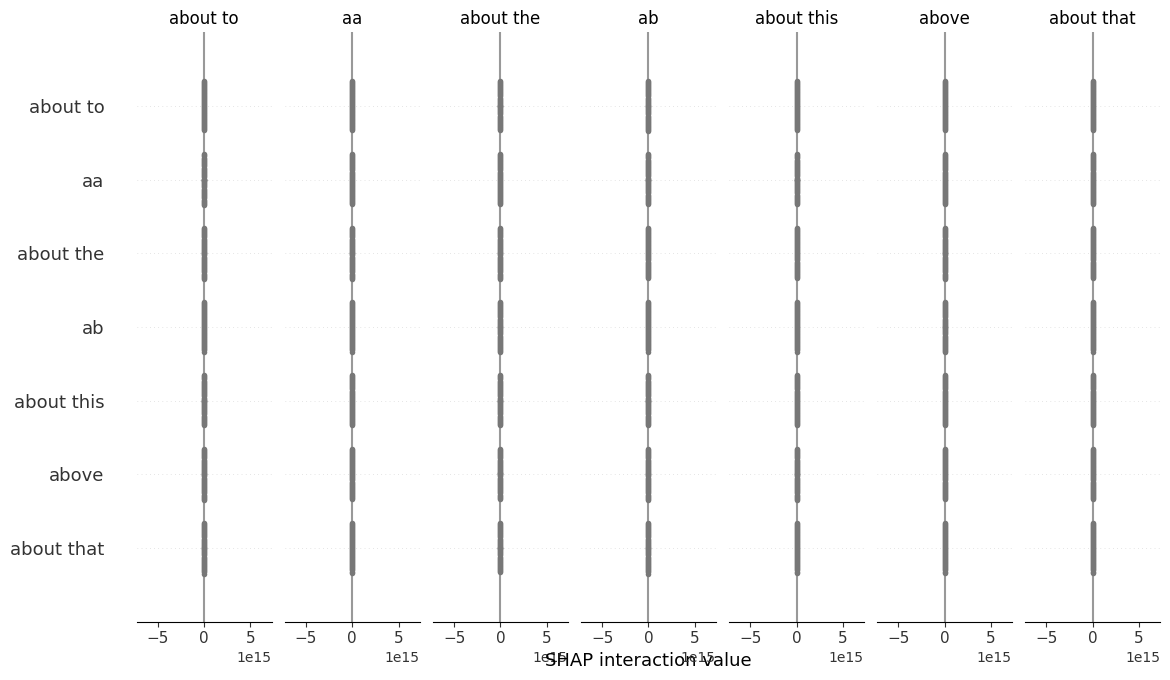

In [46]:
shap.summary_plot(shap_values, X_sample, feature_names=tfidf.get_feature_names_out())

In [49]:
model.save("mlp_document_classifier_26-9-2025.h5")